# Conv-Net

### Libraries

In [1]:
%matplotlib notebook

import numpy as np # linear algebra
import os
import pickle
import Lung_Segmentation as lung
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### Dataset

In [2]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_0.pickle', 'rb')
Images_0 = np.array(pickle.load(pickle_in))

In [3]:
Images_0.shape

(135, 60, 60, 60)

In [4]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_1.pickle', 'rb')
Images_1 = np.array(pickle.load(pickle_in))

In [5]:
Images_1.shape

(868, 60, 60, 60)

### Normalization

In [6]:
from scipy import ndimage

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_scan(image):
    """Resize volume"""
    # Normalize
    volume = normalize(image)
    
    return volume

In [7]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(image) for image in Images_0])
normal_scans = np.array([process_scan(image) for image in Images_1])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:95], normal_scans[:608]), axis=0)
y_train = np.concatenate((abnormal_labels[:95], normal_labels[:608]), axis=0)
x_val = np.concatenate((abnormal_scans[95:], normal_scans[608:]), axis=0)
y_val = np.concatenate((abnormal_labels[95:], normal_labels[608:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 703 and 300.


### Plot Images

<IPython.core.display.Javascript object>


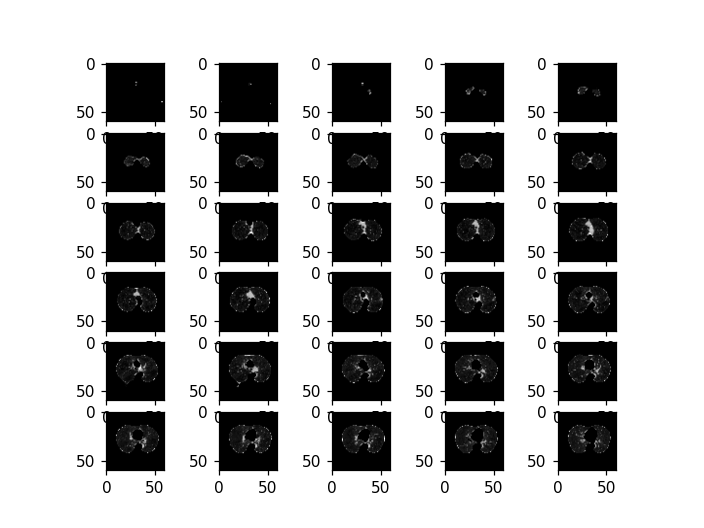

In [8]:
plt.figure()
for i in range(30):
    plt.subplot(6, 5, i+1), plt.imshow(x_train[0][i], 'gray')

### Data augmentation

In [9]:
import random

from scipy import ndimage


@tf.function

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

### Model

In [11]:
def get_model(width=60, height=60, depth=60):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=60, height=60, depth=60)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 60, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 58, 58, 58, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 29, 29, 29, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 29, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 27, 27, 27, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 13, 13, 13, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 13, 64)    256   

### Train

In [12]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_2.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
352/352 - 29s - loss: 0.4481 - acc: 0.8307 - val_loss: 1.4321 - val_acc: 0.8667
Epoch 2/100
352/352 - 24s - loss: 0.4048 - acc: 0.8521 - val_loss: 0.4691 - val_acc: 0.8700
Epoch 3/100
352/352 - 24s - loss: 0.4311 - acc: 0.8549 - val_loss: 0.5004 - val_acc: 0.8667
Epoch 4/100
352/352 - 24s - loss: 0.4074 - acc: 0.8606 - val_loss: 0.4542 - val_acc: 0.8667
Epoch 5/100
352/352 - 25s - loss: 0.3837 - acc: 0.8578 - val_loss: 0.4923 - val_acc: 0.8067
Epoch 6/100
352/352 - 26s - loss: 0.4002 - acc: 0.8634 - val_loss: 0.5510 - val_acc: 0.8667
Epoch 7/100
352/352 - 26s - loss: 0.4176 - acc: 0.8592 - val_loss: 0.4628 - val_acc: 0.8667
Epoch 8/100
352/352 - 26s - loss: 0.4066 - acc: 0.8592 - val_loss: 0.4262 - val_acc: 0.8667
Epoch 9/100
352/352 - 26s - loss: 0.3990 - acc: 0.8592 - val_loss: 0.4891 - val_acc: 0.8667
Epoch 10/100
352/352 - 26s - loss: 0.4065 - acc: 0.8620 - val_loss: 0.4625 - val_acc: 0.8667
Epoch 11/100
352/352 - 26s - loss: 0.4093 - acc: 0.8563 - val_loss: 0.4983 - va

### Visualizing model performance

<IPython.core.display.Javascript object>


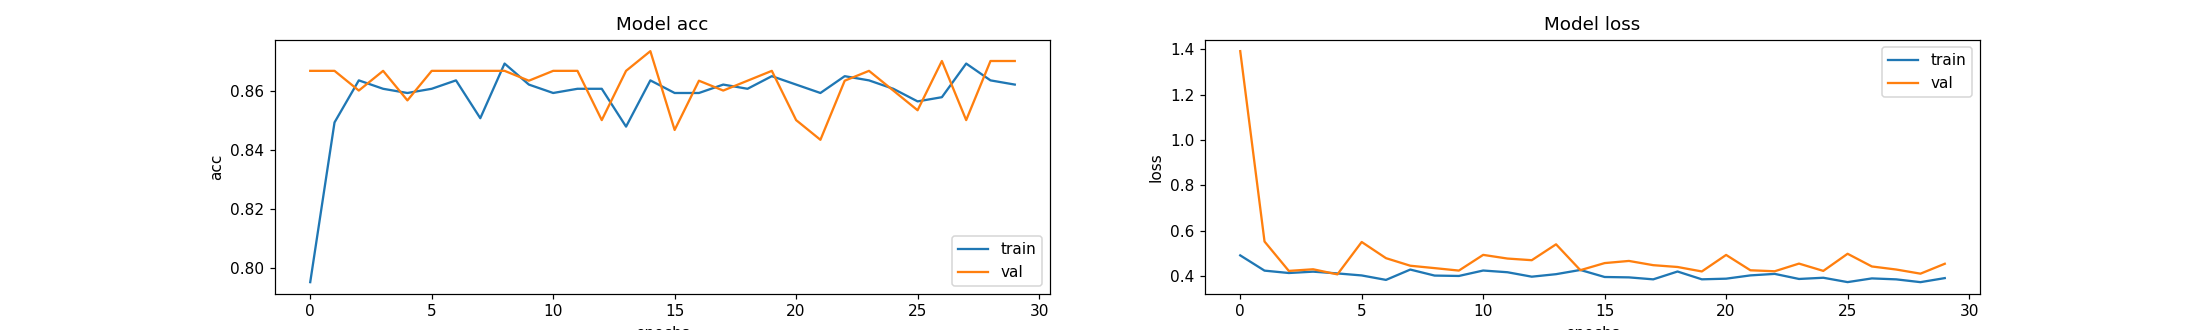

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Make predictions on a single CT scan

In [15]:
# Load best weights.
model.load_weights("3d_image_classification_2.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["nodules bigger than 3 mm", "nodules smaller than 3 mm or none"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan has %s"
        % ((100 * score), name)
    )

This model is 72.51 percent confident that CT scan has nodules bigger than 3 mm
This model is 27.49 percent confident that CT scan has nodules smaller than 3 mm or none
